In [1]:
# import all libraries and dependencies for clustering
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
from math import isnan
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
#Read the data
data = pd.read_csv("Country-data.csv")
data.head()

country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200

In [3]:
#Check the shape and info about the data
print("Shape: ", data.shape)
print("Data info: ", data.info())

Shape:  (167, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
Data info:  None


In [4]:
#Check if there are any duplicates in the data
data[data.duplicated()]

Empty DataFrame
Columns: [country, child_mort, exports, health, imports, income, inflation, life_expec, total_fer, gdpp]
Index: []

In [5]:
#Conver the below columns to their actual values
data.exports = (data.exports * data.gdpp /100)
data.health = (data.health * data.gdpp /100)
data.imports = (data.imports * data.gdpp /100)

## Data Analysis

In [6]:
col = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']

plt.figure(figsize=(15,10))
for i in enumerate(col):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(data[i[1]])

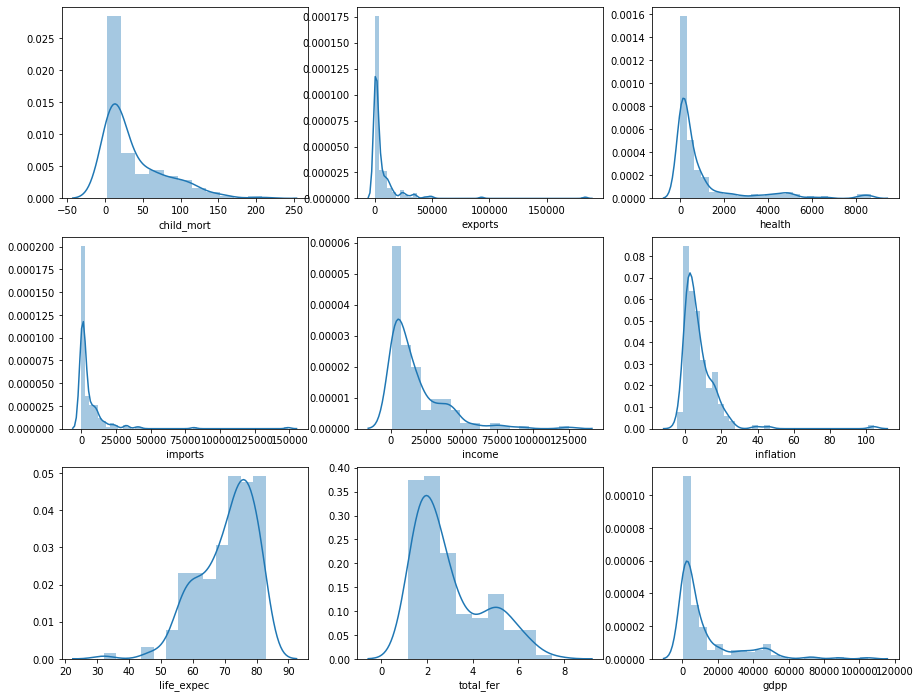

In [7]:
plt.figure(figsize=(15,12))
for i in enumerate(col):
    plt.subplot(3,3,i[0]+1)
    sns.distplot(data[i[1]])

### We can clearly see that there are outliers in the data which can influence the model.

In [8]:
#Capping technique for outliers

Q1 = data['child_mort'].quantile(0.05)
Q4 = data['child_mort'].quantile(0.95)
data['child_mort'][data['child_mort'] <= Q1] = Q1
data['child_mort'][data['child_mort'] >= Q4] = Q4


Q1 = data['exports'].quantile(0.05)
Q4 = data['exports'].quantile(0.95)
data['exports'][data['exports'] <= Q1] = Q1
data['exports'][data['exports'] >= Q4] = Q4


Q1 = data['health'].quantile(0.05)
Q4 = data['health'].quantile(0.95)
data['health'][data['health'] <= Q1] = Q1
data['health'][data['health'] >= Q4] = Q4


Q1 = data['imports'].quantile(0.05)
Q4 = data['imports'].quantile(0.95)
data['imports'][data['imports'] <= Q1] = Q1
data['imports'][data['imports'] >= Q4] = Q4


Q1 = data['income'].quantile(0.05)
Q4 = data['income'].quantile(0.95)
data['income'][data['income'] <= Q1] = Q1
data['income'][data['income'] >= Q4] = Q4


Q1 = data['inflation'].quantile(0.05)
Q4 = data['inflation'].quantile(0.95)
data['inflation'][data['inflation'] <= Q1] = Q1
data['inflation'][data['inflation'] >= Q4] = Q4


Q1 = data['life_expec'].quantile(0.05)
Q4 = data['life_expec'].quantile(0.95)
data['life_expec'][data['life_expec'] <= Q1] = Q1
data['life_expec'][data['life_expec'] >= Q4] = Q4


Q1 = data['total_fer'].quantile(0.05)
Q4 = data['total_fer'].quantile(0.95)
data['total_fer'][data['total_fer'] <= Q1] = Q1
data['total_fer'][data['total_fer'] >= Q4] = Q4


Q1 = data['gdpp'].quantile(0.05)
Q4 = data['gdpp'].quantile(0.95)
data['gdpp'][data['gdpp'] <= Q1] = Q1
data['gdpp'][data['gdpp'] >= Q4] = Q4


In [9]:
plt.figure(figsize=(15,10))
for i in enumerate(col):
    plt.subplot(3,3,i[0]+1)
    sns.boxplot(data[i[1]])

We can see that most of the outliers are taken care of. We canâ€™t remove the rest outliers as we might loose important data.

(9.0, 0.0)

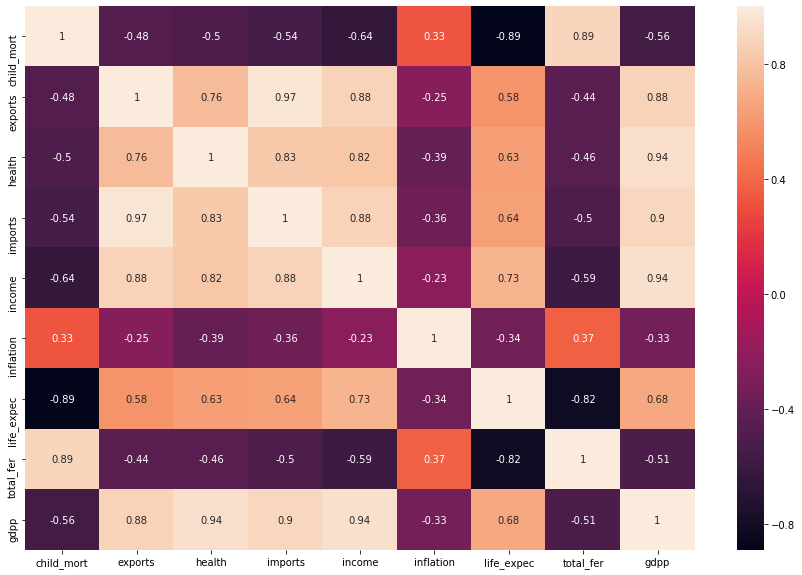

In [10]:
#Bivariate Analysis of the data
plt.figure(figsize = (15,10))        
ax = sns.heatmap(data.corr(),annot = True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [11]:
sns.pairplot(data)

In [12]:
data_km = data.copy()
data_hc = data.copy()
data.drop('country', axis=1, inplace=True)
data.head()

child_mort    exports    health   imports   income  inflation  life_expec  \
0        90.2    70.4688   41.9174   248.297   1610.0       9.44        56.2   
1        16.6  1145.2000  267.8950  1987.740   9930.0       4.49        76.3   
2        27.3  1712.6400  185.9820  1400.440  12900.0      16.10        76.5   
3       116.0  2199.1900  100.6050  1514.370   5900.0      20.87        60.1   
4        10.3  5551.0000  735.6600  7185.800  19100.0       1.44        76.8   

   total_fer     gdpp  
0      5.820    553.0  
1      1.650   4090.0  
2      2.890   4460.0  
3      5.861   3530.0  
4      2.130  12200.0

In [13]:
#Standardizing the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [14]:
data_scaled

array([[ 1.47958789, -0.66803864, -0.62977844, ..., -1.82530988,
         2.02071786, -0.7578739 ],
       [-0.56002364, -0.54238923, -0.47380714, ...,  0.68245351,
        -0.88733091, -0.52377507],
       [-0.26350403, -0.47604845, -0.53034406, ...,  0.70740638,
        -0.02258739, -0.49928636],
       ...,
       [-0.37435248, -0.56600553, -0.59686482, ...,  0.2832076 ,
        -0.67811877, -0.70777132],
       [ 0.54014725, -0.63033074, -0.61187406, ..., -0.41547275,
         1.21873798, -0.70777132],
       [ 1.28283189, -0.61312123, -0.59935647, ..., -1.8777109 ,
         1.72782086, -0.69784347]])

In [15]:
data_scaled = pd.DataFrame(data_scaled)
data_scaled.columns = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']
data_scaled.head()

child_mort   exports    health   imports    income  inflation  life_expec  \
0    1.479588 -0.668039 -0.629778 -0.733291 -0.960575   0.387667   -1.825310   
1   -0.560024 -0.542389 -0.473807 -0.472674 -0.395590  -0.404004    0.682454   
2   -0.263504 -0.476048 -0.530344 -0.560668 -0.193907   1.452825    0.707406   
3    2.194560 -0.419165 -0.589272 -0.543598 -0.669255   2.215708   -1.338729   
4   -0.734610 -0.027297 -0.150953  0.306143  0.227115  -0.891802    0.744836   

   total_fer      gdpp  
0   2.020718 -0.757874  
1  -0.887331 -0.523775  
2  -0.022587 -0.499286  
3   2.049310 -0.560839  
4  -0.552591  0.012991

In [16]:
#Performing Hopkins Test

def hopkins(X):
    d = X.shape[1]
    n = len(X)
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [17]:
hopkins(data_scaled)

0.8540336232506622

In [18]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(data_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(range_n_clusters, ssd)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

In [19]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
ss = []
for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(data_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    ss.append([num_clusters, silhouette_score(data_scaled, cluster_labels)])

For n_clusters=2, the silhouette score is 0.48447902987180524
For n_clusters=3, the silhouette score is 0.4203919640787207
For n_clusters=4, the silhouette score is 0.3879858729916906
For n_clusters=5, the silhouette score is 0.32452711684285457
For n_clusters=6, the silhouette score is 0.3351998465158624
For n_clusters=7, the silhouette score is 0.3330569265473599
For n_clusters=8, the silhouette score is 0.34588765004987176


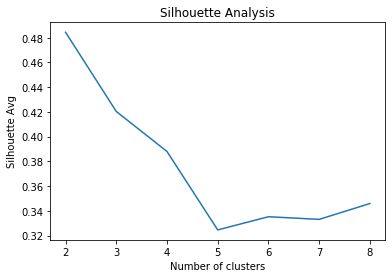

In [20]:
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Avg')
plt.title('Silhouette Analysis')
plt.plot(pd.DataFrame(ss)[0], pd.DataFrame(ss)[1])
plt.show()

In [21]:
#Performing K-Means for 3 clusters
cluster3 = KMeans(n_clusters=3, max_iter=50, random_state= 100)
cluster3.fit(data_scaled)
print(cluster3.labels_)
data_km3 = pd.concat([data_km, pd.Series(cluster3.labels_)], axis=1)

data_km3.columns = ['country','child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp','labels']
data_km3.labels.value_counts()

[2 1 1 2 1 1 1 0 0 1 0 0 1 1 1 0 1 2 1 1 1 2 1 0 1 2 2 1 2 0 1 2 2 1 1 1 2
 2 2 1 2 1 0 0 0 1 1 1 1 2 2 1 1 0 0 2 2 1 0 2 0 1 1 2 2 1 2 1 0 1 1 1 2 0
 0 0 1 0 1 1 2 2 0 1 2 1 1 2 2 1 1 0 1 2 2 1 1 2 0 2 1 1 1 1 1 1 2 1 2 1 0
 0 2 2 0 1 2 1 1 1 1 1 0 0 1 1 2 1 1 2 1 1 2 0 0 0 2 2 0 0 1 1 2 1 0 0 1 2
 1 2 2 1 1 1 1 2 1 0 0 0 1 1 1 1 1 2 2]


1    82
2    48
0    37
Name: labels, dtype: int64

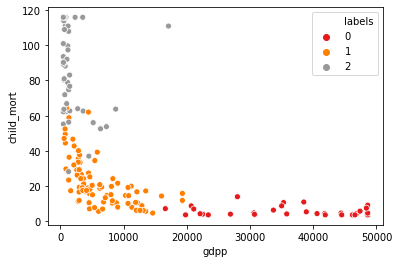

In [22]:
#Plotting GDPP vs Child Mortality
sns.scatterplot(x='gdpp', y='child_mort', hue = 'labels', data= data_km3, palette = "Set1")

In [23]:
#Plotting GDPP vs Income
sns.scatterplot(x='gdpp', y='income', hue = 'labels', data= data_km3, palette = "Set1")

In [24]:
#Plotting Child Mortality vs Income
sns.scatterplot(x='child_mort', y='income', hue = 'labels', data= data_km3, palette = "Set1")

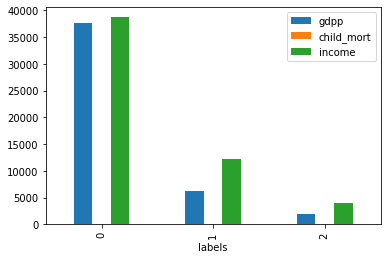

In [25]:
#Analyzing the clusters for GDPP, Child Mortality and Income for 3 clusters
data_km3[['gdpp','child_mort','income','labels']].groupby('labels').mean().plot(kind='bar')

In [26]:
#Since the Child Mortality was not visible in previous graph we analyze it separately
data_km3[['child_mort','labels']].groupby('labels').mean().plot(kind='bar')

In [27]:
#Performing K-Means for 4 clusters
cluster4 = KMeans(n_clusters=4, max_iter=50, random_state= 100)
cluster4.fit(data_scaled)
print(cluster4.labels_)
data_km4 = pd.concat([data_km, pd.Series(cluster4.labels_)], axis=1)

data_km4.columns = ['country','child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp','labels']
data_km4.labels.value_counts()

[2 0 0 2 0 0 0 3 1 0 3 3 0 3 0 1 0 2 0 0 0 2 0 3 0 2 2 0 2 1 0 2 2 0 0 0 2
 2 2 0 2 0 3 3 1 0 0 0 0 2 2 3 0 1 3 2 2 0 1 2 3 0 0 2 2 0 2 3 1 0 0 0 2 1
 3 3 0 3 0 0 2 2 3 0 2 0 0 2 2 0 0 1 0 2 2 0 0 2 1 2 0 0 0 0 0 0 2 0 2 0 1
 3 2 2 1 3 2 0 0 0 0 0 3 1 0 0 2 0 3 2 0 3 2 1 3 3 2 2 3 3 0 0 2 0 1 1 0 2
 0 2 2 0 0 0 0 2 0 1 3 3 0 0 0 0 0 2 2]


0    76
2    48
3    26
1    17
Name: labels, dtype: int64

In [28]:
#Plotting Child Mortality vs GDPP
sns.scatterplot(x='gdpp', y='child_mort', hue = 'labels', data= data_km4, palette = "Set1")

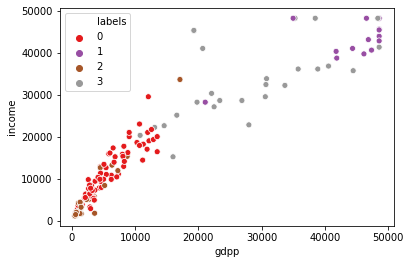

In [29]:
#Plotting GDPP vs Income
sns.scatterplot(x='gdpp', y='income', hue = 'labels', data= data_km4, palette = "Set1")

In [30]:
#Plotting Child Mortality vs Income
sns.scatterplot(x='child_mort', y='income', hue = 'labels', data= data_km4, palette = "Set1")

In [31]:
#Analyzing the clusters for GDPP, Child Mortality and Income
data_km4[['gdpp','child_mort','income','labels']].groupby('labels').mean().plot(kind='bar')

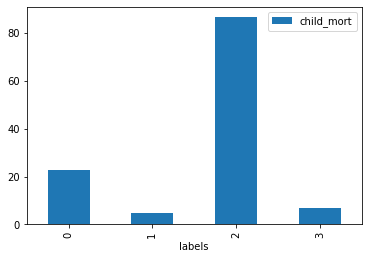

In [32]:
#Since the Child Mortality was not visible in previous graph we analyze it separately
data_km4[['child_mort','labels']].groupby('labels').mean().plot(kind='bar')

# Hierarchical Clustering

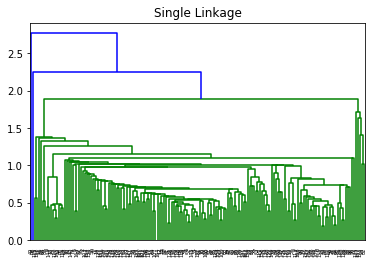

In [33]:
# Single linkage

mergings = linkage(data_scaled, method='single',metric='euclidean')
dendrogram(mergings)
plt.title("Single Linkage")
plt.show()

We see that the single linkage doesn't provide the clear picture. Hence we perform Complete Linkage

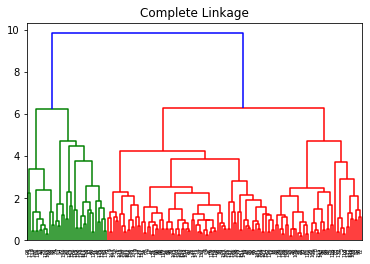

In [34]:
# Complete Linkage

mergings = linkage(data_scaled, method='complete',metric='euclidean')
dendrogram(mergings)
plt.title("Complete Linkage")
plt.show()

In [35]:
# From the above dendogram we decide to go ahead with 4 clusters
cluster_labels = cut_tree(mergings, n_clusters=4).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 3, 1, 2, 2, 1, 1, 1, 3, 1, 0, 1, 1, 1, 1,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2,
       3, 1, 1, 1, 1, 0, 0, 1, 1, 3, 2, 0, 0, 1, 3, 0, 2, 1, 1, 0, 0, 1,
       0, 1, 3, 1, 1, 1, 0, 3, 2, 2, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0,
       0, 2, 1, 3, 1, 0, 0, 1, 1, 0, 3, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       3, 2, 0, 0, 3, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 0, 1, 1,
       0, 3, 2, 2, 1, 1, 2, 2, 1, 1, 0, 1, 3, 3, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [36]:
data_hc['Cluster_id'] = cluster_labels
data_hc.head()

country  child_mort    exports    health   imports   income  \
0          Afghanistan        90.2    70.4688   41.9174   248.297   1610.0   
1              Albania        16.6  1145.2000  267.8950  1987.740   9930.0   
2              Algeria        27.3  1712.6400  185.9820  1400.440  12900.0   
3               Angola       116.0  2199.1900  100.6050  1514.370   5900.0   
4  Antigua and Barbuda        10.3  5551.0000  735.6600  7185.800  19100.0   

   inflation  life_expec  total_fer     gdpp  Cluster_id  
0       9.44        56.2      5.820    553.0           0  
1       4.49        76.3      1.650   4090.0           1  
2      16.10        76.5      2.890   4460.0           1  
3      20.87        60.1      5.861   3530.0           0  
4       1.44        76.8      2.130  12200.0           1

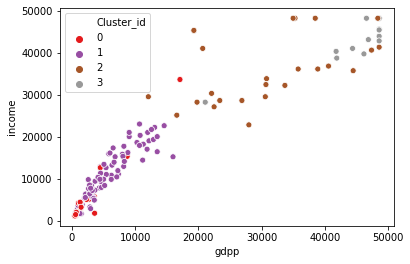

In [37]:
#Plotting GDPP vs Income
sns.scatterplot(x='gdpp', y='income', hue = 'Cluster_id', data= data_hc, palette = "Set1")

In [38]:
#Plotting Child Mortality vs Income
sns.scatterplot(x='child_mort', y='income', hue = 'Cluster_id', data= data_hc, palette = "Set1")

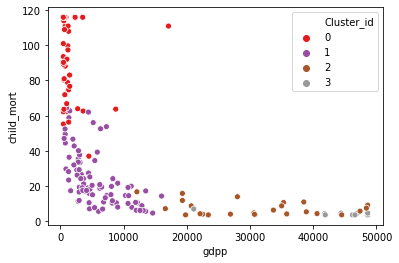

In [39]:
#Plotting Child Mortality vs GDPP
sns.scatterplot(x='gdpp', y='child_mort', hue = 'Cluster_id', data= data_hc, palette = "Set1")

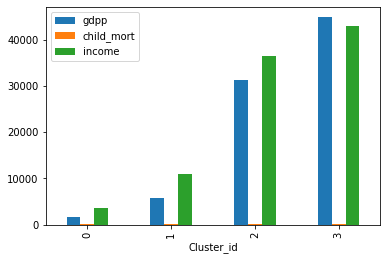

In [40]:
#Analyzing the clusters for GDPP, Child Mortality and Income
data_hc[['gdpp','child_mort','income','Cluster_id']].groupby('Cluster_id').mean().plot(kind='bar')

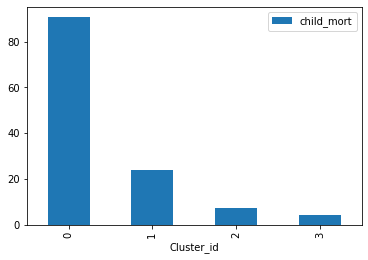

In [41]:
#Since the Child Mortality was not visible in previous graph we analyze it separately
data_hc[['child_mort','Cluster_id']].groupby('Cluster_id').mean().plot(kind='bar')

### We see that both the clustering methods are showing similar clusters. However from the scatterplots above we notice that the kmeans clusters look well defined.

We are looking for countries with Low income, Low GDPP and High Child mortality rate. 

In [42]:
countries = data_km3[data_km3.labels == 1][['country', 'child_mort', 'income', 'gdpp']]

In [43]:
#We sort the countries based on low GDPP, low income and high Chile Mortality rate
df_help = countries.sort_values(['gdpp','child_mort', 'income'], ascending=[True, False, True]).head().reset_index()
df_help = df_help.drop('index', axis=1)
df_help.head()

country  child_mort  income   gdpp
0            Nepal        47.0  1990.0  592.0
1       Tajikistan        52.4  2110.0  738.0
2       Bangladesh        49.4  2440.0  758.0
3         Cambodia        44.4  2520.0  786.0
4  Kyrgyz Republic        29.6  2790.0  880.0

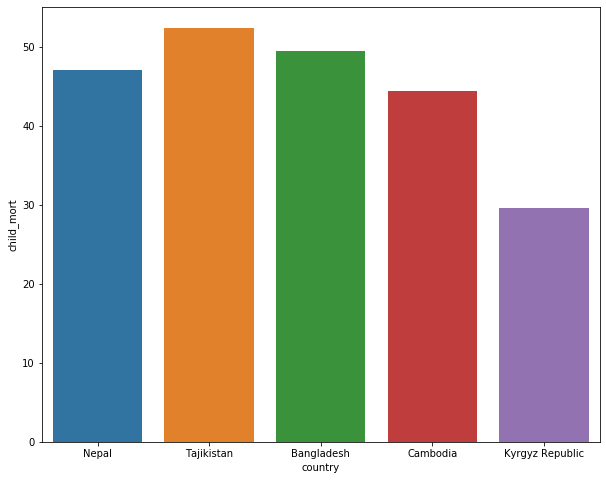

In [44]:
plt.figure(figsize=(10,8))
sns.barplot(x='country', y='child_mort', data=df_help)
plt.show()

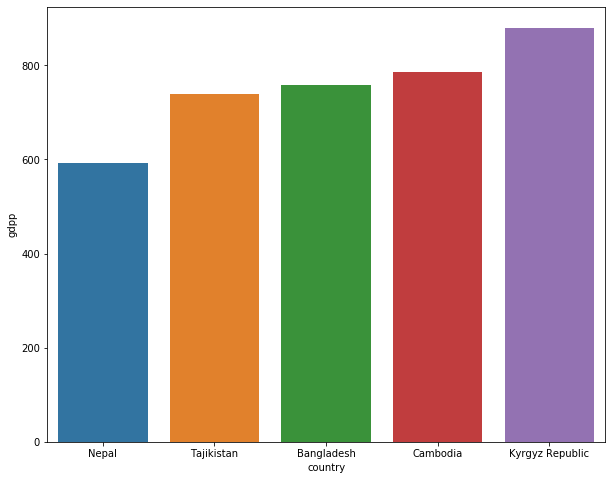

In [45]:
plt.figure(figsize=(10,8))
sns.barplot(x='country', y='gdpp', data=df_help)
plt.show()

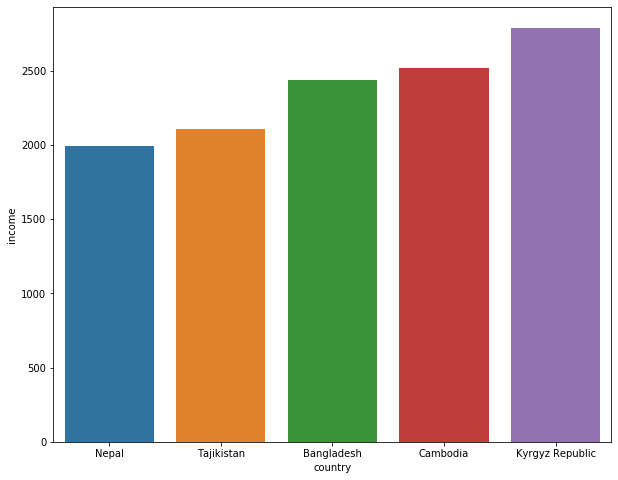

In [46]:
plt.figure(figsize=(10,8))
sns.barplot(x='country', y='income', data=df_help)
plt.show()